# Kaggle Dog breed
Classify dog breed in Kaggle competition

In [40]:
import numpy as np

original_train_dir = './data/train'
original_test_dir = './data/test'
train_labels = np.loadtxt('./data/labels.csv', delimiter=',', dtype=str, skiprows=1)
# Remove missing data
train_labels = train_labels[train_labels[:, 0] != '000bec180eb18c7604dcecc8fe0dba07']
clazzes, counts = np.unique(train_labels[:, 1], return_counts=True)
print("Some classes with count:")
print np.asarray((clazzes, counts)).T[0:10]
print("Number of class: %d" % clazzes.size)

Some classes with count:
[['affenpinscher' '80']
 ['afghan_hound' '116']
 ['african_hunting_dog' '86']
 ['airedale' '107']
 ['american_staffordshire_terrier' '74']
 ['appenzeller' '78']
 ['australian_terrier' '102']
 ['basenji' '110']
 ['basset' '82']
 ['beagle' '105']]
Number of class: 120


## Copy data

In [41]:
import os, shutil

def mkdirIfNotExist(directory):
    if not os.path.exists(directory):
        os.mkdir(directory)
    return directory

base_dir = mkdirIfNotExist('./data/data_gen')
train_dir = mkdirIfNotExist(os.path.join(base_dir, 'train'))
validation_dir = mkdirIfNotExist(os.path.join(base_dir, 'validation'))
test_dir = mkdirIfNotExist(os.path.join(base_dir, 'test'))
for clazz in clazzes:
    mkdirIfNotExist(os.path.join(train_dir, clazz))
    mkdirIfNotExist(os.path.join(validation_dir, clazz))

In [42]:
# Copy first 600 files
def copyIfNotExist(fnames, src_dir, dst_dir):
    nCopied = 0
    for fname in fnames:
        src = os.path.join(src_dir, fname)
        dst = os.path.join(dst_dir, fname)
        if not os.path.exists(dst):
            shutil.copyfile(src, dst)
            nCopied += 1
    if nCopied > 0:
        print("Copied %d to %s" % (nCopied, dst_dir))

            
train_ratio = 0.7
for clazz in clazzes:
    fnames = train_labels[train_labels[:, 1] == clazz][:,0]
    fnames = ['{}.jpg'.format(name) for name in fnames]
    idx = int(len(fnames)*train_ratio)
    train_fnames = fnames[:idx]
    val_fnames = fnames[idx:]
    train_class_dir = os.path.join(train_dir, clazz)
    validation_class_dir = os.path.join(validation_dir, clazz)
    copyIfNotExist(train_fnames, original_train_dir, train_class_dir)
    copyIfNotExist(val_fnames, original_train_dir, validation_class_dir)

Copied 60 to ./data/data_gen/train/boston_bull
Copied 26 to ./data/data_gen/validation/boston_bull
Copied 60 to ./data/data_gen/train/bouvier_des_flandres
Copied 26 to ./data/data_gen/validation/bouvier_des_flandres
Copied 52 to ./data/data_gen/train/boxer
Copied 23 to ./data/data_gen/validation/boxer
Copied 46 to ./data/data_gen/train/brabancon_griffon
Copied 21 to ./data/data_gen/validation/brabancon_griffon
Copied 46 to ./data/data_gen/train/briard
Copied 20 to ./data/data_gen/validation/briard
Copied 51 to ./data/data_gen/train/brittany_spaniel
Copied 22 to ./data/data_gen/validation/brittany_spaniel
Copied 52 to ./data/data_gen/train/bull_mastiff
Copied 23 to ./data/data_gen/validation/bull_mastiff
Copied 74 to ./data/data_gen/train/cairn
Copied 32 to ./data/data_gen/validation/cairn
Copied 53 to ./data/data_gen/train/cardigan
Copied 23 to ./data/data_gen/validation/cardigan
Copied 58 to ./data/data_gen/train/chesapeake_bay_retriever
Copied 25 to ./data/data_gen/validation/chesape

## Data generator

In [43]:
from keras.preprocessing.image import ImageDataGenerator

rescale_size = 255
batch_size = 10

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./rescale_size)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(rescale_size, rescale_size),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(rescale_size, rescale_size),
        batch_size=batch_size,
        class_mode='categorical')

Using TensorFlow backend.


Found 7157 images belonging to 120 classes.
Found 3120 images belonging to 120 classes.


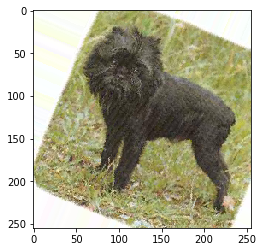

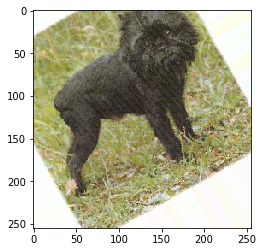

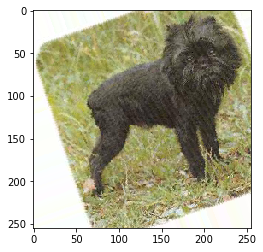

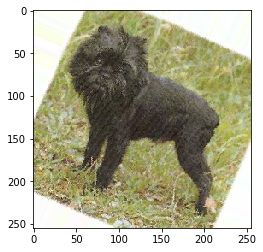

In [44]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

train_first_dir = os.path.join(train_dir, clazzes[0])
fnames = [os.path.join(train_first_dir, fname) for fname in os.listdir(train_first_dir)]

img_path = fnames[3]
img = image.load_img(img_path, target_size=(rescale_size, rescale_size))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

## Extract feature with pretrained model

In [48]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(rescale_size, rescale_size, 3))
conv_base.trainable = False

## Define Neural Net

In [51]:
from keras import layers, models, regularizers, optimizers
from keras.models import Sequential,  Model
from keras.layers import Flatten, Dense, Dropout

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(120, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_4 (Dense)              (None, 120)               30840     
Total params: 21,168,312
Trainable params: 6,453,624
Non-trainable params: 14,714,688
_________________________________________________________________


## Train model

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=80,
      epochs=3,
      validation_data=validation_generator,
      validation_steps=40)

model.save('dog_breed_pretrain_vgg16_1800_img.h5py')

Epoch 1/3
80/80 [==============================] - 1477s - loss: 4.8169 - acc: 0.0088 - val_loss: 4.8026 - val_acc: 0.0100
Epoch 2/3
63/80 [======================>.......] - ETA: 272s - loss: 4.8077 - acc: 0.0095

## Evaluation

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')

plt.show()